# $\longrightarrow$ LIE GROUP REPRESENTATION ESTIMATION $\longleftarrow$

Lie-PCA paper: https://arxiv.org/pdf/2008.04278.pdf

Henrique thesis: https://www.overleaf.com/project/629a2646158ff1593e76807d

**Note:** Our algorithm may not converge every time, therefore it may be necessary to run it multiple times to obtain satisfactory results. This is due to the possibility of getting stuck in local minimum, while using the *Stiefel* of *Grassmann* method.

# Functions

In [4]:
import liedetect
import sklearn, scipy
import matplotlib.pyplot as plt
import velour
import numpy as np

# Experiments I - Torus

## I-1: Representation of $\mathrm{SO}(2)$

### I-1-a: Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^4$

We start with a simple example: a representation of $\mathrm{SO}(2)$ in dimension $4$.
Our goal is to recover the frequencies of the representation. We first generate the point cloud.

-----> Representation of T^1 in R^4
frequencies: ((3, 4),)


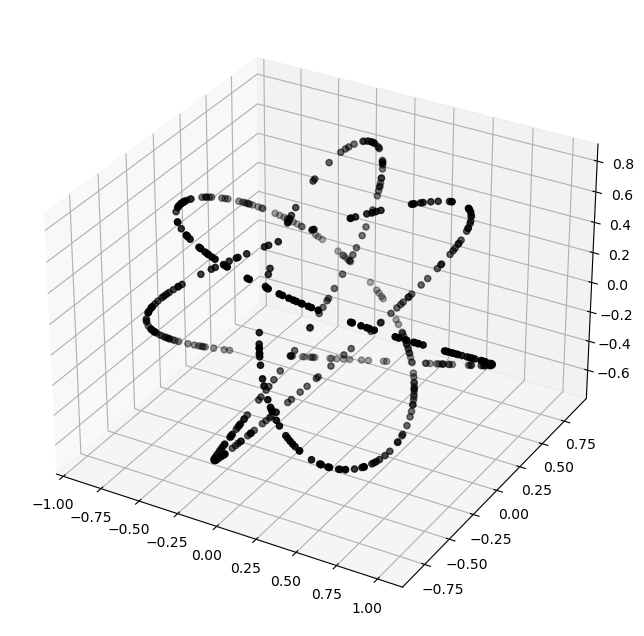

In [2]:
' Generate dataset '

# Parameters
ambient_dim = 4     # ambient dimension
dim = 1             # dimension of the torus (here, circle)
n_points = 500      # number of sample points
frequency_max = 4   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra = liedetect.datasets.SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                              conjugate=True,right_multiply=True,verbose=True)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');

Next, we apply Lie-PCA. Two methods are available: with local covariance, that do not use pruning of the eigenvectors, and with local PCA, that does. On both methods, we already see that the Lie-PCA operator has one significantly small eigenvalue. This is an indicator of the fact that the underlying orbit is generated by $\mathrm{SO}(2)$.

In [3]:
' Lie-PCA '

n_neighbors = 10
method='localcovariance'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

method='localPCA'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.0012308360332441133, 0.11030141907169669, 0.11130004238306174, 0.11893191723907949]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0003103861941649488, 0.11277767131127424, 0.11652752115141185, 0.12316690566550847]


We now find the Lie algebra more likely to generate the orbit underlying the point cloud, based on the Lie-PCA operator. 
To this end, we implemented three methods: one consists in an optimisation on $\mathrm{O}(n)\times\mathrm{O}(d)$, one on $\mathrm{O}(n)$, and the last one is based in the normal form decomposition of the skew-symmetric matrices.
We see that the three methods allow to recover exactly the frequencies, and give an accurate estimation of the underlying orbit.

----> Optimization problem via Stiefel <----
Frequencies ((1, 2),) - result 0.0011497870790015696
Frequencies ((1, 3),) - result 0.002661461948182986
Frequencies ((1, 4),) - result 0.0035181725510178563
Frequencies ((2, 3),) - result 0.00020447664722010594
Frequencies ((3, 4),) - result 1.8883969630759703e-06
The optimal frequencies found is  ((3, 4),) with cost  1.8883969630759703e-06
Non-symmetric Hausdorff distance from X to estimated orbit: 0.07417223317933164 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.14185732957899852


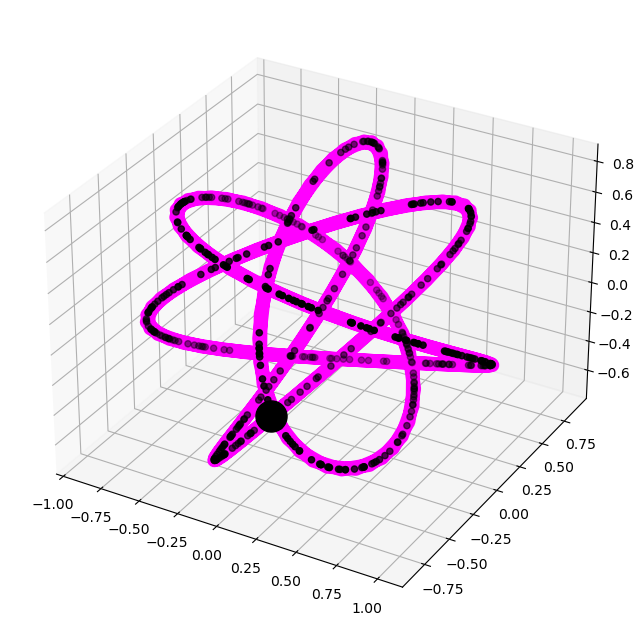

----> Optimization problem via Grassmann <----
Frequencies ((1, 2),) - result 0.0654432822810107
Frequencies ((1, 3),) - result 0.2024535255910193
Frequencies ((1, 4),) - result 0.3040993383021861
Frequencies ((2, 3),) - result 0.006613840981676468
Frequencies ((3, 4),) - result 8.315576888848462e-06
The optimal frequencies found is ((3, 4),) with cost 8.315576888848462e-06
Non-symmetric Hausdorff distance from X to estimated orbit: 0.07438646357102191 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.14216894144678754


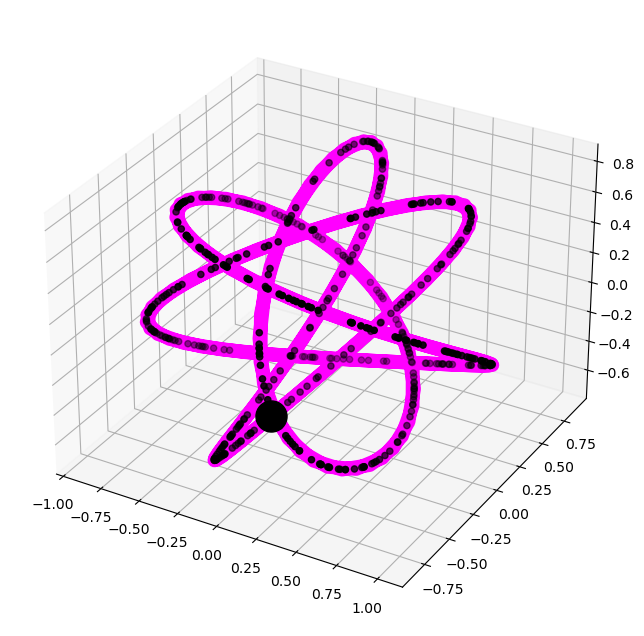

----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.6016300048078209, 0.7987748977746743)
The optimal frequencies found is  ((3, 4),) with cost  0.002039066241203945
Non-symmetric Hausdorff distance from X to estimated orbit: 0.07438778741266962 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.14216473360653586


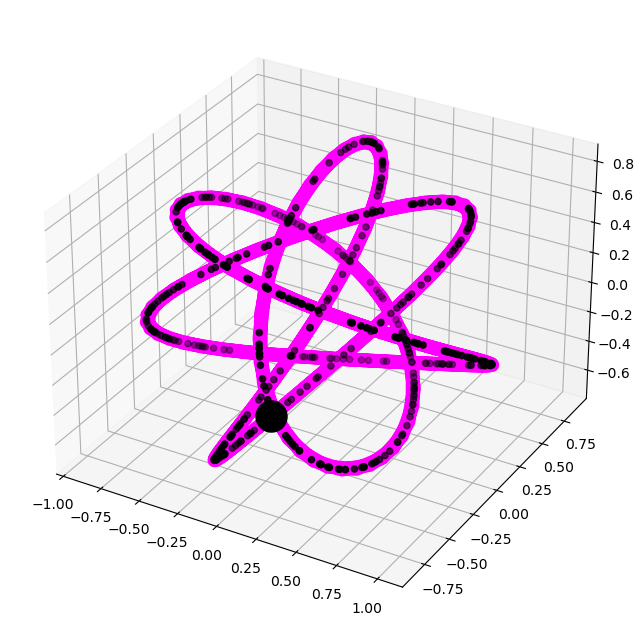

In [4]:
' Project on Lie subalgebras '

for method in ['Stiefel', 'Grassmann', 'NormalForm']:

    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                                  method=method,verbosity=1)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, 
                                                          n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show()

### I-1-b: Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^6$

We reproduce the same experiment, $\mathrm{SO}(2)$ being now represented in dimension $6$.

-----> Representation of T^1 in R^6
frequencies: ((1, 2, 3),)


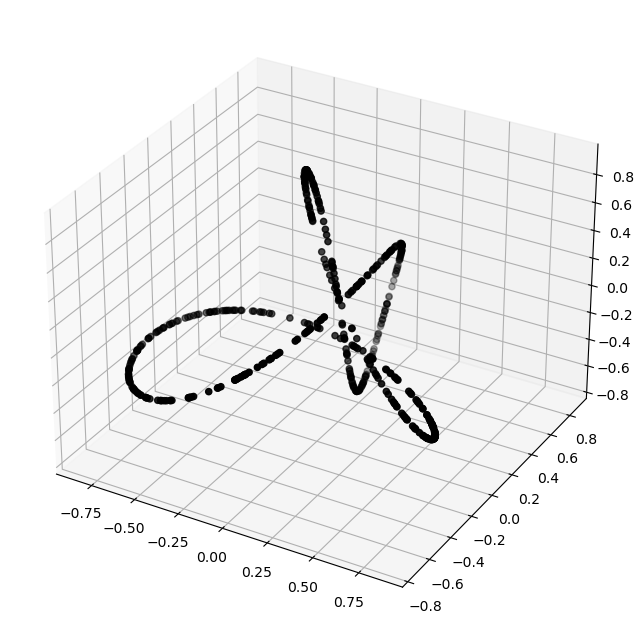

In [5]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
dim = 1             # dimension of the torus (here, circle)
n_points = 500      # number of sample points
frequency_max = 3   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra = liedetect.datasets.SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, 
                                                 frequency_max=frequency_max, conjugate=True,right_multiply=True,verbose=True)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');

In [6]:
' Lie-PCA '

n_neighbors = 5
method='localcovariance'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

method='localPCA'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.00023608496922029713, 0.055023683060810985, 0.0571680945465798, 0.0739077141867775]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [9.481857692484865e-05, 0.05564966190905048, 0.05722944079390161, 0.07457778772325703]


----> Optimization problem via Stiefel <----
There are 1 frequencies to test.
Frequencies ((1, 2, 3),) - result 0.0047111605347927325
(Terminated - min grad norm reached after 777 iterations, 99.69 seconds.)
The optimal frequencies found is  ((1, 2, 3),) with cost  0.0047111605347927325
Non-symmetric Hausdorff distance from X to estimated orbit: 1.3244204057945292 
Non-symmetric Hausdorff distance from estimated orbit to X: 1.0223778059793738


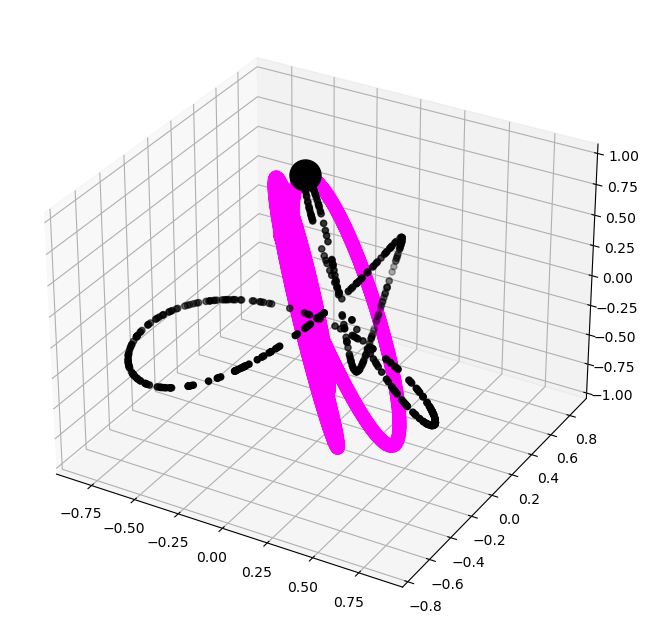

----> Optimization problem via Grassmann <----
There are 1 frequencies to test.
Frequencies ((1, 2, 3),) - result 0.5311210752978158
(Terminated - min grad norm reached after 91 iterations, 29.73 seconds.)
The optimal frequencies found is ((1, 2, 3),) with cost 0.5311210752978158
Non-symmetric Hausdorff distance from X to estimated orbit: 1.0196675346799327 
Non-symmetric Hausdorff distance from estimated orbit to X: 1.0157035783622186


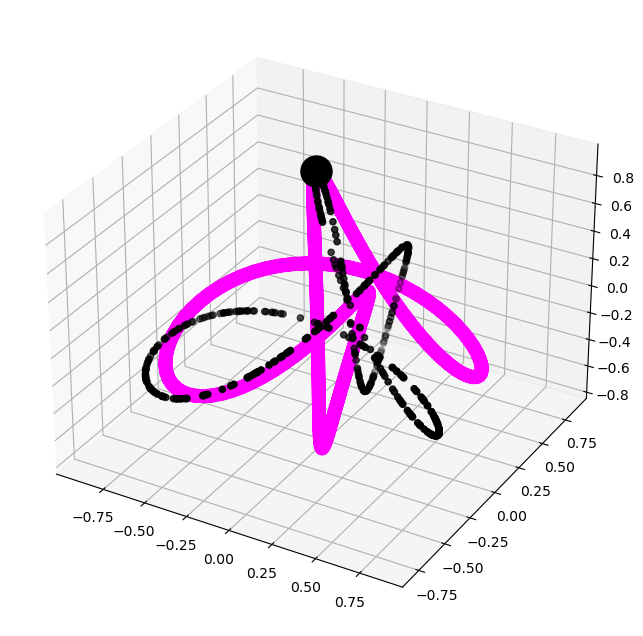

----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.267538743210631, 0.5347416984349471, 0.8015449686924521)
The optimal frequencies found is  ((1, 2, 3),) with cost  0.0004266930304547032
Non-symmetric Hausdorff distance from X to estimated orbit: 0.04553037158594206 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.09277544553745881


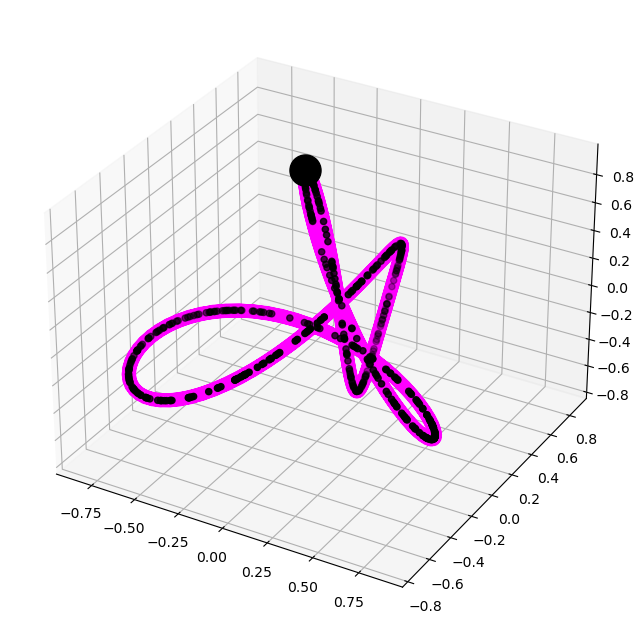

In [7]:
' Project on Lie subalgebras '

for method in ['Stiefel', 'Grassmann', 'NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method,verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show()

### I-1-c: PCA pre-processing

The consistency of our method is based on the assumption that the underlying orbit lives in a minimal-dimensional subspace. If not, the isometry group $\mathrm{Isom}(\mathcal{O})$ is not equal to the symmetry group $\mathrm{Sym}(\mathcal{O})$, and our algorithm may return inconsistent Lie algebras.
This is the case for the point cloud below.

-----> Representation of T^1 in R^6
frequencies: ((1, 2, 3),)


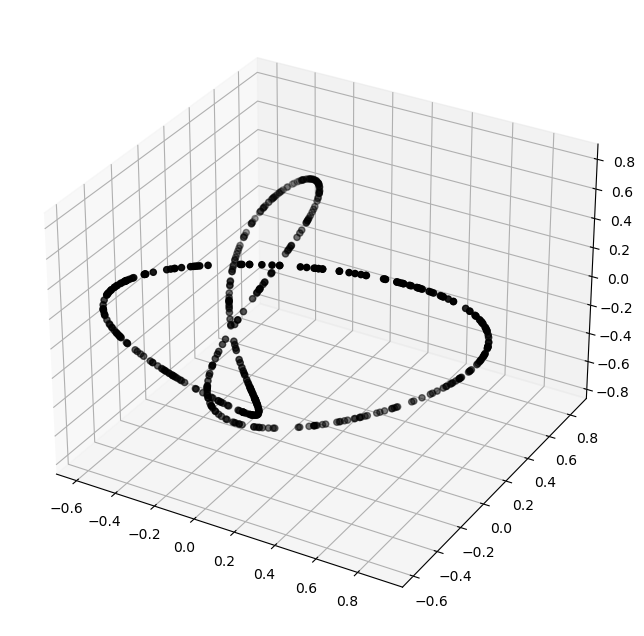

In [8]:
' Generate dataset '

# Parameters
ambient_dim = 6       # ambient dimension
dim = 1               # dimension of the torus (here, circle)
n_points = 500        # number of sample points
frequencies = ((1,1,2),) # prescribed frequencies

# Generate dataset and plot
X, LieAlgebra = liedetect.datasets.SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                              conjugate=False,right_multiply=False,verbose=True)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');

In [9]:
' Lie-PCA '

n_neighbors = 5
method='localcovariance'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.00020264056440301017, 0.055126548053399366, 0.059340922912047366, 0.0755991343763598]


----> Optimization problem via Stiefel <----
Frequencies ((1, 2, 3),) - result 0.004670230058583955
The optimal frequencies found is  ((1, 2, 3),) with cost  0.004670230058583955
Non-symmetric Hausdorff distance from X to estimated orbit: 0.9776692014363199 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.9671798043455831


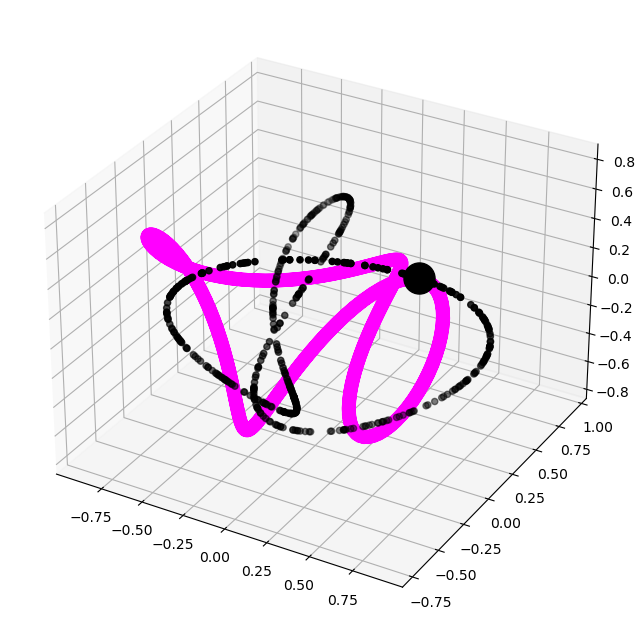

In [10]:
' Project on Lie subalgebras '

for method in ['Stiefel']:

    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method,verbosity=1)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show()

In order to remedy to this problem, we project the point cloud in a minimal-dimensional subspace.
Applying our algorithm again gives accurate results.

In [11]:
' Project in minimal-dimensional subspace '

# Prune small PCA eigenvalues
eps_pca = 1e-10
pca = sklearn.decomposition.PCA(n_components=ambient_dim); pca.fit(X)
dim_pca = sum(pca.explained_variance_ratio_>eps_pca)
print('Projection in dimension', dim_pca, '- PCA eigenvalues:', sorted(pca.explained_variance_ratio_))

# Dimension reduction via PCA
pca = sklearn.decomposition.PCA(n_components=dim_pca); 
X = pca.fit_transform(X)
ambient_dim = dim_pca

Projection in dimension 6 - PCA eigenvalues: [0.14052715852263903, 0.15446992711102606, 0.16378590194707773, 0.16616372807884786, 0.18030715479653392, 0.19474612954387546]


----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0005008721857563451, 0.05482926593388382, 0.05869849981210564, 0.07484795606438964]
----> Optimization problem via Stiefel <----
Frequencies ((1, 2, 3),) - result 0.004087691015235033
The optimal frequencies found is  ((1, 2, 3),) with cost  0.004087691015235033
Non-symmetric Hausdorff distance from X to estimated orbit: 1.2229343099570518 
Non-symmetric Hausdorff distance from estimated orbit to X: 1.131590685896549


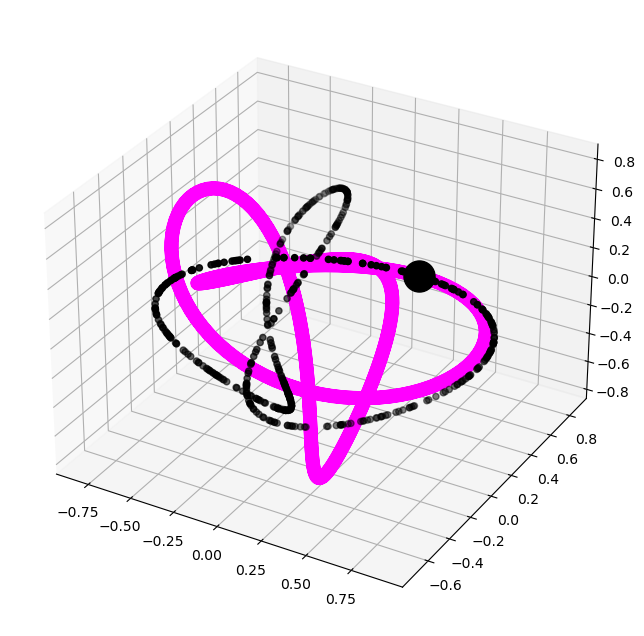

----> Optimization problem via Grassmann <----
Frequencies ((1, 2, 3),) - result 0.5312629534329578
The optimal frequencies found is ((1, 2, 3),) with cost 0.5312629534329578
Non-symmetric Hausdorff distance from X to estimated orbit: 1.0319318184960151 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.9909876240050961


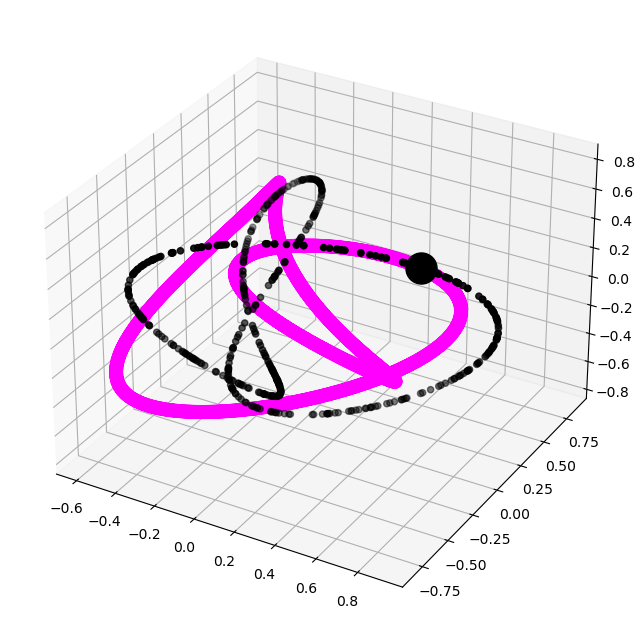

----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.267616034371547, 0.5348374105832225, 0.8014553028010235)
The optimal frequencies found is  ((1, 2, 3),) with cost  0.0005769906214531885
Non-symmetric Hausdorff distance from X to estimated orbit: 0.09154847928496557 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.09626641825108509


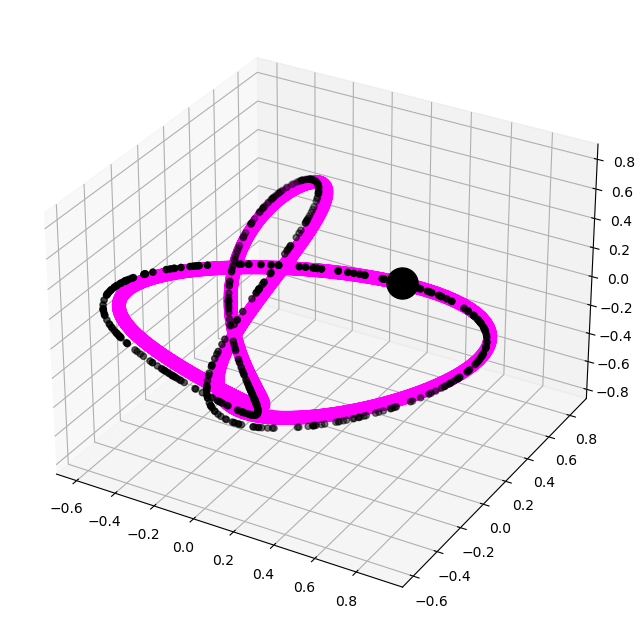

In [12]:
' Lie-PCA '

n_neighbors = 5
method='localPCA'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)
' Project on Lie subalgebras '

frequency_max = 3
for method in ['Stiefel', 'Grassmann', 'NormalForm']:

    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method,verbosity=1)
    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 200
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show()

## I-2: Representation of $T^2$

### I-2-a: Representation of $T^2$ in $\mathbb{R}^6$

-----> Representation of T^2 in R^6
frequencies: ((1, 1, 2), (1, 2, 1))


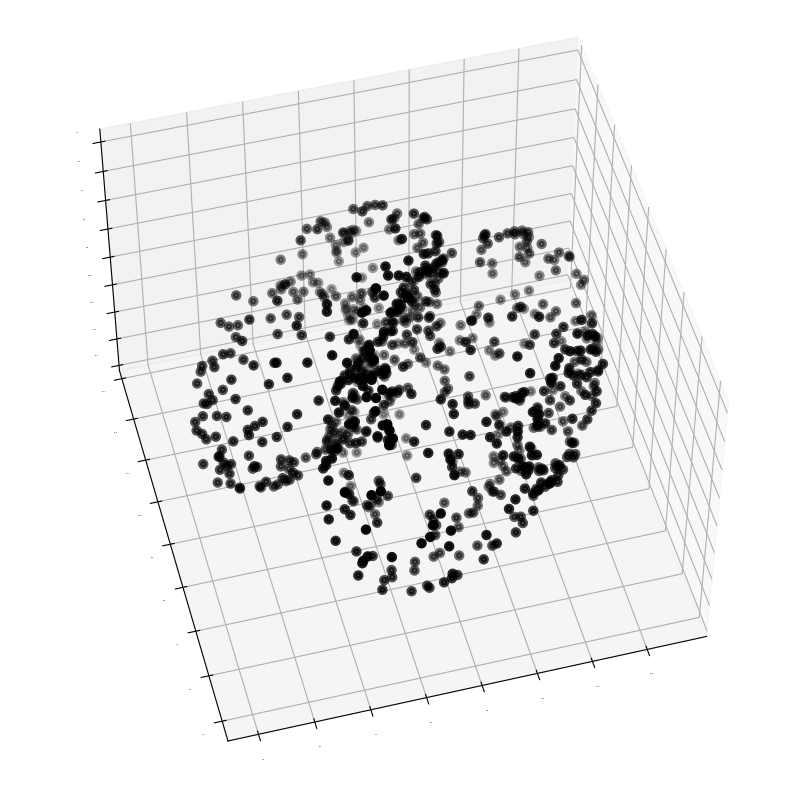

In [13]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
dim = 2             # dimension of the torus 
n_points = 750      # number of sample points
frequency_max = 2   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra = liedetect.datasets.SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                              conjugate=True,right_multiply=False,verbose=True)
%matplotlib inline
velour.PlotPCA(X); plt.show();

In [14]:
' Check minimal-dimensional subspace '

eps_pca = 1e-10
pca = sklearn.decomposition.PCA(n_components=ambient_dim); pca.fit(X)
print('Minimal subspace has dimension', sum(pca.explained_variance_ratio_>eps_pca))

' Lie-PCA '

n_neighbors = 15
for method in ['localcovariance','localPCA']:
    Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

Minimal subspace has dimension 6
----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.005869799704156168, 0.014194137851600471, 0.053751789604890084, 0.05999540425630054]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0020139503844667033, 0.0022391688180993146, 0.06340152181534556, 0.06658117431636602]


----> Optimization problem via Stiefel <----
Frequencies ((1, 1, 2), (1, 2, 1)) - result 3.5232509550121245e-05
Frequencies ((1, 1, 2), (1, 2, 2)) - result 0.002925033051198494
Frequencies ((1, 2, 2), (2, 1, 2)) - result 0.007942728165648484
The optimal frequencies found is  ((1, 1, 2), (1, 2, 1)) with cost  3.5232509550121245e-05
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0508568996176103 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.40623725042200215


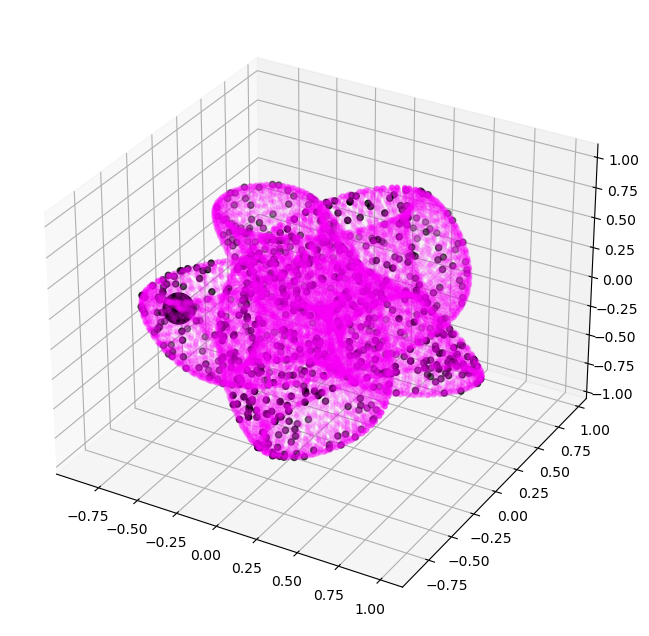

----> Optimization problem via Grassmann <----
Frequencies ((1, 1, 2), (1, 2, 1)) - result 0.0017852569125444678
Frequencies ((1, 1, 2), (1, 2, 2)) - result 0.22794590225007802
Frequencies ((1, 2, 2), (2, 1, 2)) - result 0.6682066457494006
The optimal frequencies found is ((1, 1, 2), (1, 2, 1)) with cost 0.0017852569125444678
Non-symmetric Hausdorff distance from X to estimated orbit: 0.053724051099916875 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.40641196141009994


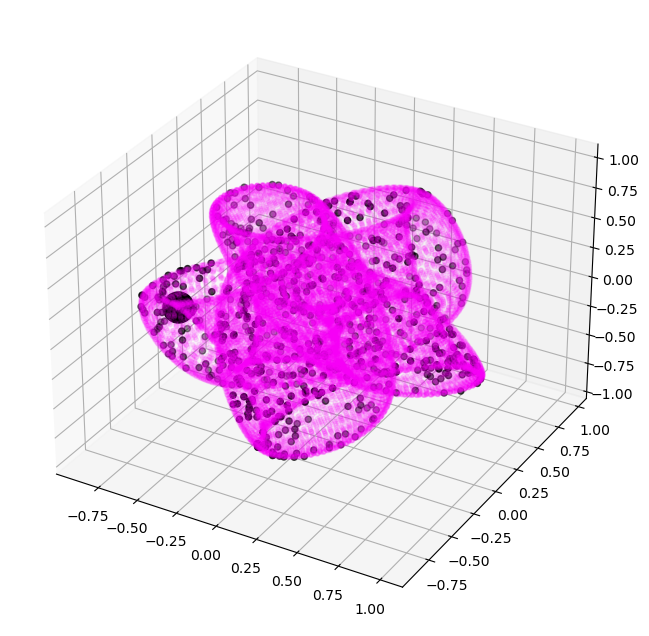

----> Optimization problem via NormalForm <----
Test commutation: 0.018592057797246254
The optimal frequencies found is ((1, 1, 2), (2, 1, 1)) cost: 0.02991552354615251
              ---> equivalent to ((1, 1, 2), (1, 2, 1))
Non-symmetric Hausdorff distance from X to estimated orbit: 0.10096804509382472 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.40905834318664797


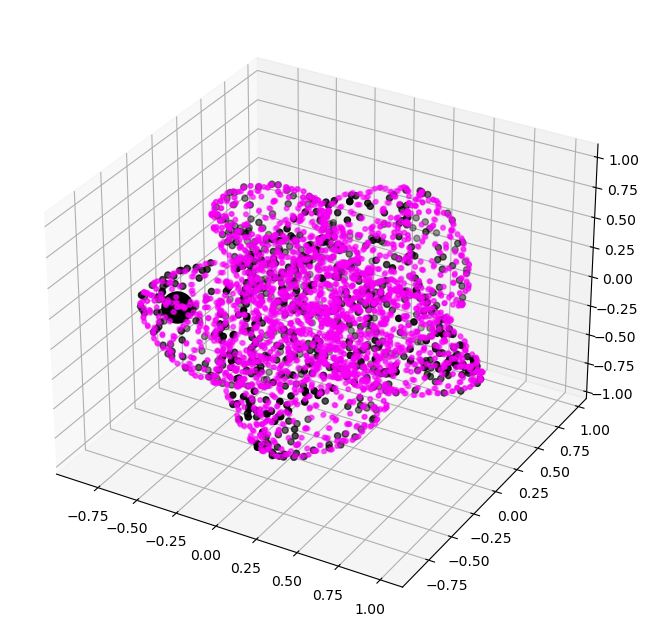

In [15]:
' Project on Lie subalgebras '

for method in ['Stiefel','Grassmann','NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                         frequency_max=frequency_max,
                                                                                         method=method)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=10,alpha=0.1); plt.show();

### I-2-b: Representation of $T^2$ in $\mathbb{R}^8$

-----> Representation of T^2 in R^8
frequencies: ((1, 1, 2, 3), (1, 3, 1, 3))


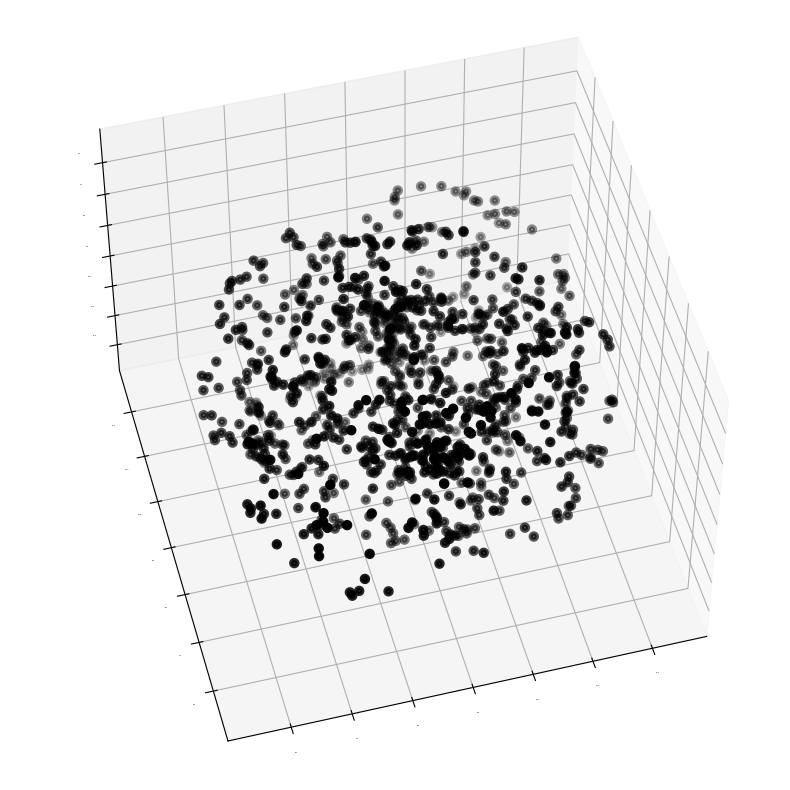

In [16]:
' Generate dataset '

# Parameters
ambient_dim = 8     # ambient dimension
dim = 2             # dimension of the torus 
n_points = 1000      # number of sample points
frequency_max = 3   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra = liedetect.datasets.SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                              conjugate=True,right_multiply=False,verbose=True)
%matplotlib inline
velour.PlotPCA(X); plt.show();

In [17]:
' Check minimal-dimensional subspace '

eps_pca = 1e-10
pca = sklearn.decomposition.PCA(n_components=ambient_dim); pca.fit(X)
print('Minimal subspace has dimension', sum(pca.explained_variance_ratio_>eps_pca))

' Lie-PCA '

n_neighbors = 15
for method in ['localcovariance','localPCA']:
    Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

Minimal subspace has dimension 8
----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.006867975274531604, 0.01716312023635389, 0.043224109717757954, 0.04572314883443749]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0020535236710565764, 0.0027670357151798794, 0.05064532240350899, 0.05509078569966991]


**Warning:** The following cell takes a lot of time to run. This is because of the orbit generation, which consists of $200\times 200\times 200$ points.

----> Optimization problem via NormalForm <----
Test commutation: 0.016434708361997973
The optimal frequencies found is ((1, -2, -1, 3), (3, -1, -1, 3)) cost: 0.0395520606191349
              ---> equivalent to ((1, 1, 2, 3), (1, 3, 1, 3))
Non-symmetric Hausdorff distance from X to estimated orbit: 0.05838341347211633 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.5110935974636727


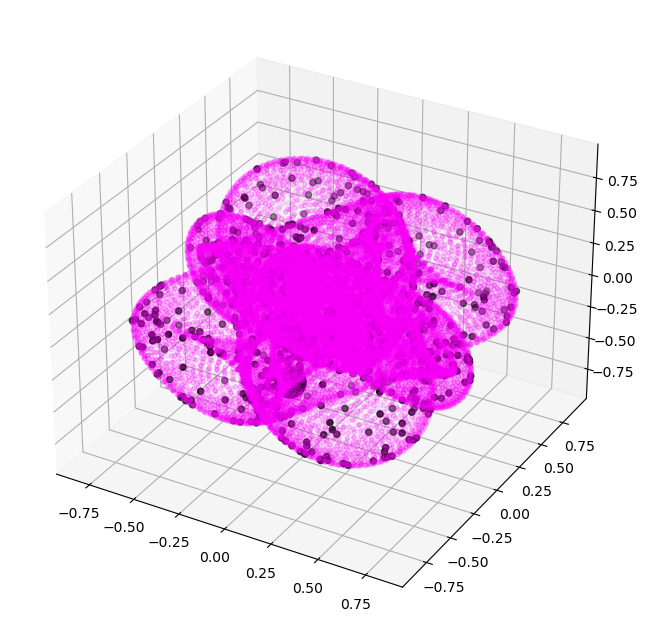

In [18]:
' Project on Lie subalgebras '

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 200
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=10,alpha=0.1); plt.show();

## I-2: Representation of $T^3$ in $\mathbb{R}^6$

-----> Representation of T^3 in R^6
frequencies: ((1, 1, 2), (1, 3, 3), (3, 2, 2))


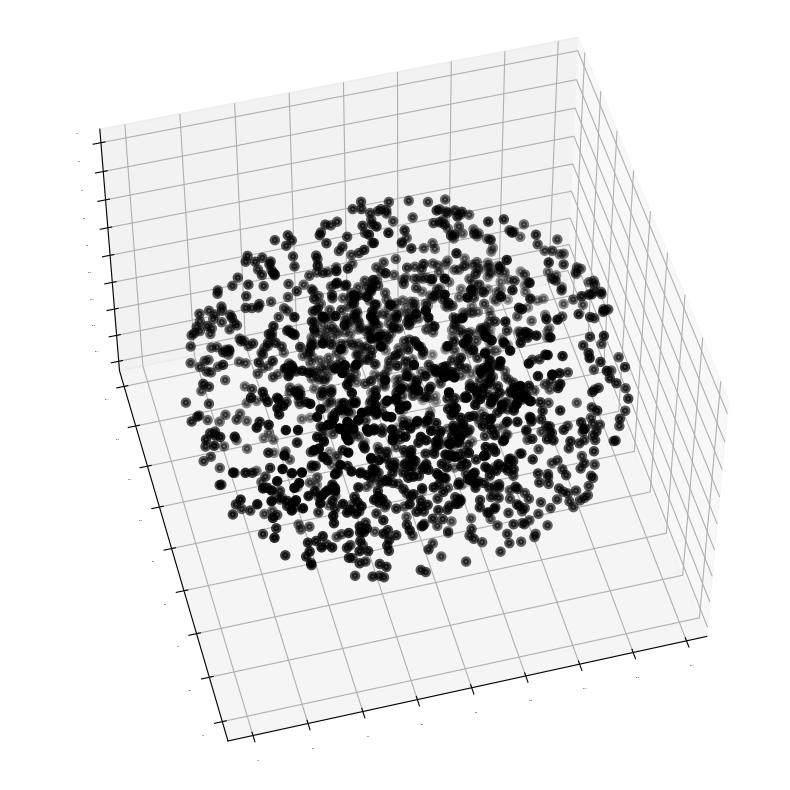

In [19]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
dim = 3             # dimension of the torus 
n_points = 1500     # number of sample points
frequency_max = 3   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra = liedetect.datasets.SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                              conjugate=True,right_multiply=False,verbose=True)
%matplotlib inline
velour.PlotPCA(X); plt.show();

In [20]:
' Check minimal-dimensional subspace '

eps_pca = 1e-10
pca = sklearn.decomposition.PCA(n_components=ambient_dim); pca.fit(X)
print('Minimal subspace has dimension', sum(pca.explained_variance_ratio_>eps_pca))

' Lie-PCA '

n_neighbors = 15
for method in ['localcovariance','localPCA']:
    Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

Minimal subspace has dimension 6
----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.0071845943202134945, 0.010027536215637078, 0.01293879046114188, 0.060499506166908655]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.002304457778538295, 0.0025614092139535894, 0.0026448869885988837, 0.06314095694295632]


In [21]:
' Project on Lie subalgebras '

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method, verbosity = 2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

----> Optimization problem via NormalForm <----
Test commutation: 0.01043316037109638
There are 432 frequencies to test.
The optimal frequencies found is ((2, 3, 1), (2, 3, 2), (2, 3, 3)) cost: 6.19701888742333e-16
              ---> equivalent to ((1, 2, 3), (2, 2, 3), (3, 2, 3))
Non-symmetric Hausdorff distance from X to estimated orbit: 0.49349918401652537 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.42719598725628555


# Experiments II: pixels permutations

## Experiment II-1: linear images

We consider a set of $1\times n$ images obtained by applying cyclic permutations to the vector [1,1,0,...,0].
We obtain a dataset of $n$ images.

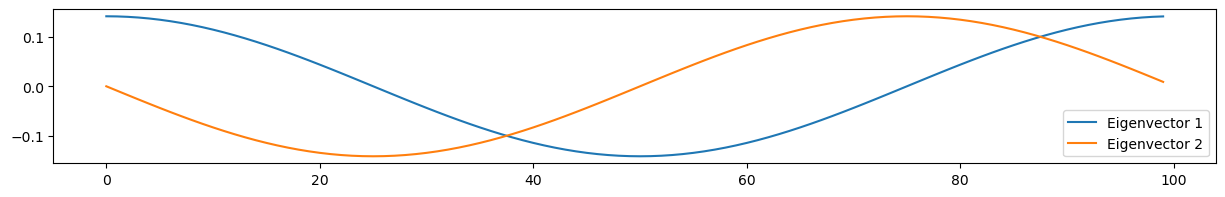

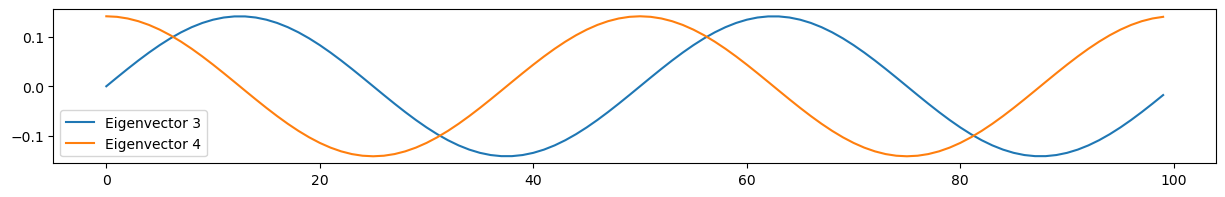

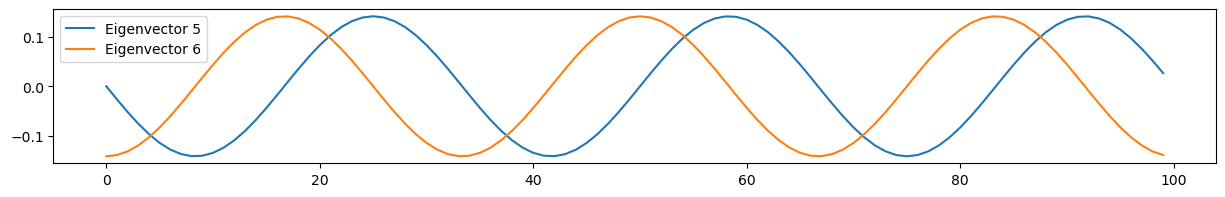

In [22]:
' Generate 1xn images '

n = 100
x0 = np.zeros((n)); 
x0[0] = 1; x0[1] = 1;
X = [np.roll(x0, i) for i in range(n)]

' Plot the eigenvectors of PCA '

pca = sklearn.decomposition.PCA(n_components=n); pca.fit(X)

for I in range(3):
    plt.figure(figsize=(15,2))
    for i in range(2): plt.plot(pca.components_[2*I+i])
    plt.legend(['Eigenvector '+repr(2*I+1),'Eigenvector '+repr(2*I+2)])

In [23]:
' Generate dataset '

# Parameters
ambient_dim = 8     # dimension to reduce the dataset
dim = 1              # dimension of the torus (here, circle)

# PCA
pca = sklearn.decomposition.PCA(n_components=ambient_dim); 
X = pca.fit_transform(X)

In [24]:
' Lie-PCA '

n_neighbors = 5
method='localPCA'
Sigma =  liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0012593269548526417, 0.03435676223369829, 0.034922777512930644, 0.05669975080888622]


----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.19013535846865814, 0.37593350511865226, 0.5533067245924032, 0.7185918269156877)
The optimal frequencies found is  ((1, 2, 3, 4),) with cost  0.01848454558980272
Non-symmetric Hausdorff distance from X to estimated orbit: 0.031158840675416424 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.050607979460839975


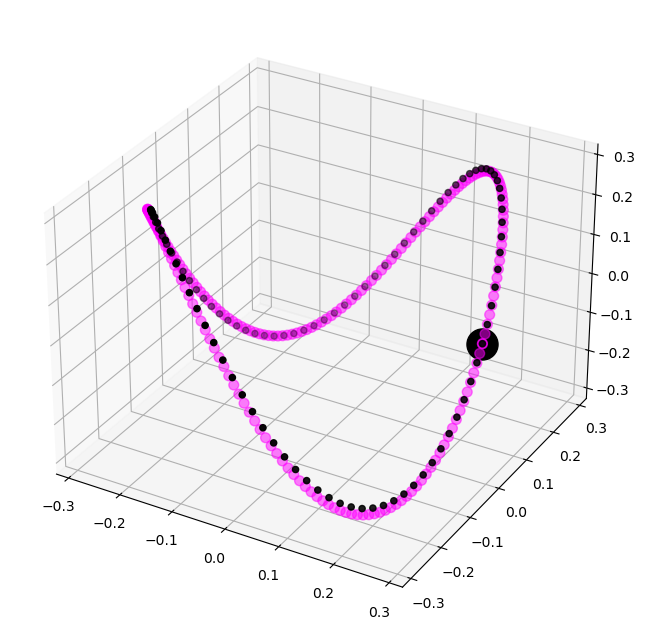

In [25]:
' Project on Lie subalgebras '

frequency_max = 10

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method, verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 200
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=50,alpha=0.5); plt.show();

We observe the following interesting phenomenon: the frequencies form the integer progression 1, 2, 3, 4, ...
This has to do with circle Fourier series. Note that if we increase the value of **ambient_dim**, we will see this pattern going on.

## Experiment II-2: $\mathbb{S}^1$ action on translated gorillas

shape X: (65, 46800)


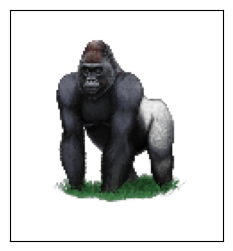

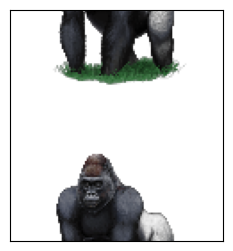

In [2]:
X = liedetect.datasets.GorillaImages(dim = 1, verbosity = 2)

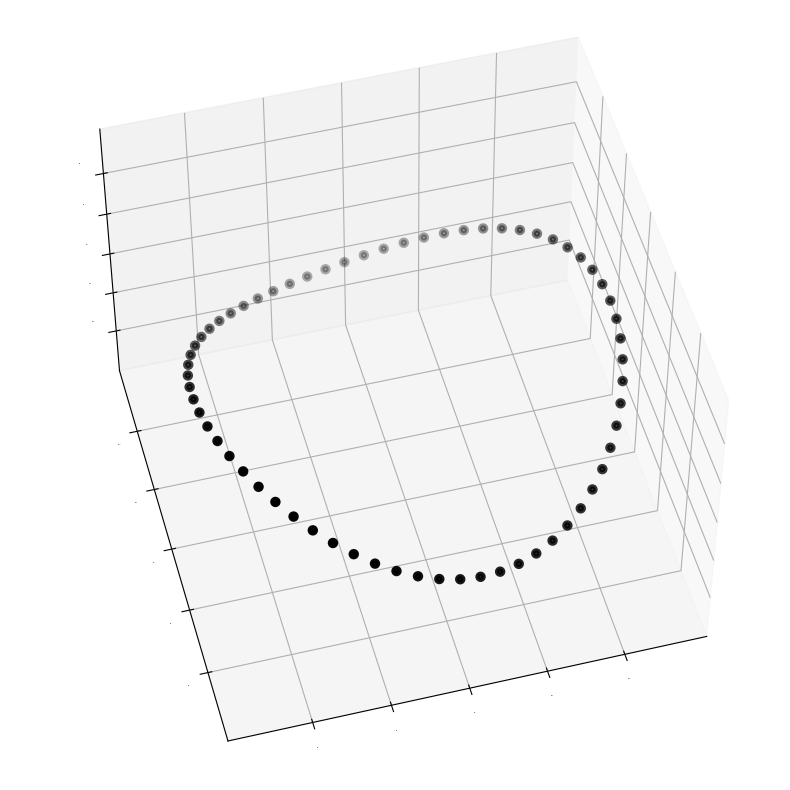

In [3]:
' Generate dataset '

# Parameters
dim = 1             # dimension of the torus (here, circle)
frequency_max = 3   # maximal angle parameter

# PCA
dim_pca = 6
ambient_dim = dim_pca
pca = sklearn.decomposition.PCA(n_components=dim_pca)
X = pca.fit_transform(X)

velour.PlotPCA(X); plt.show();

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0005961456054455702, 0.018152314477547973, 0.018260663837922207, 0.018833639979435986]


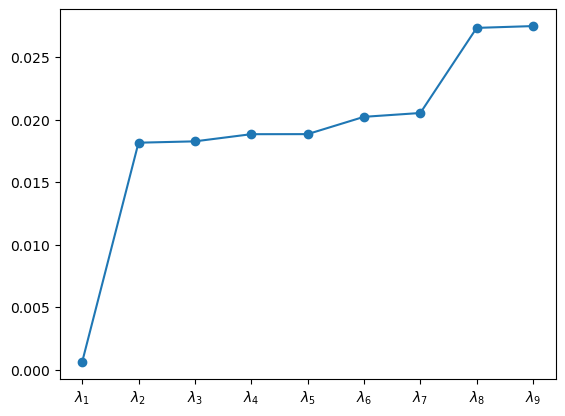

In [21]:
' Lie-PCA '

n_neighbors = 5


method='localPCA'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors, dim_pca,dim=dim,method=method)

vals, _ = np.linalg.eig(Sigma) #finds eigenvalues and vectors of sigma as a matrix
vals = np.real(vals)
indices = np.argsort(vals)
vals = [vals[i] for i in indices]

lambdas = [r'$\lambda_' + str(i) + '$' for i in range(1, 10)]
plt.plot(lambdas, vals[:9], '-o')
plt.show()

----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.27809415764060563, 0.5477550928572649, 0.7890678030024361)
The optimal frequencies found is  ((1, 2, 3),) with cost  0.021310764790992455
Non-symmetric Hausdorff distance from X to estimated orbit: 0.007112881162501593 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.01909023796397086


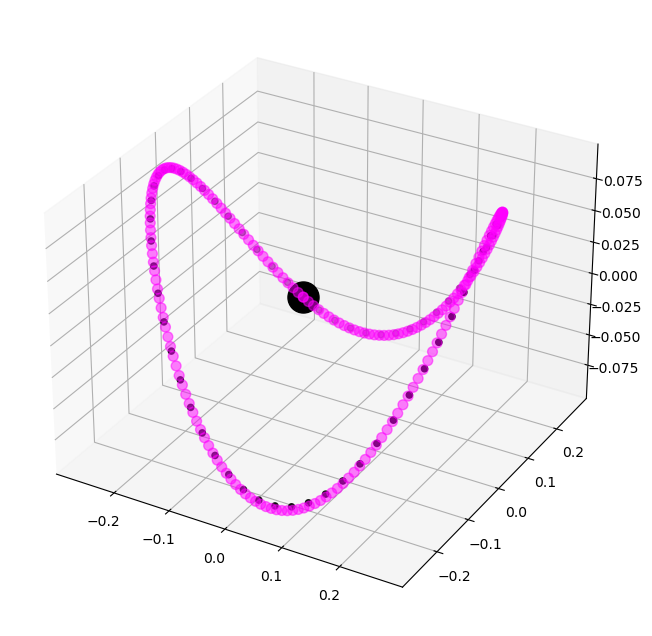

In [5]:
' Project on Lie subalgebras '

frequency_max = 10

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method, verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 200
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=50,alpha=0.5); plt.show();

## Experiment II-3: $\mathbb{T}^2$ action on translated gorillas

shape X: (65, 60, 46800)


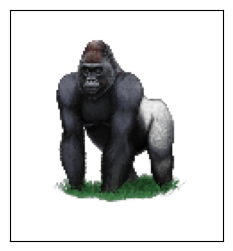

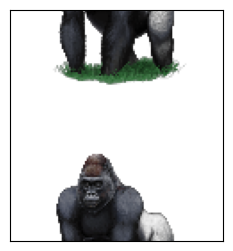

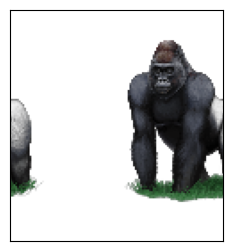

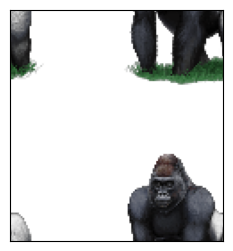

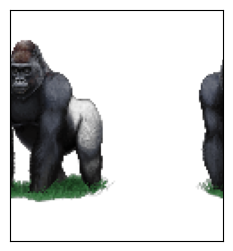

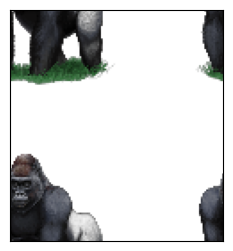

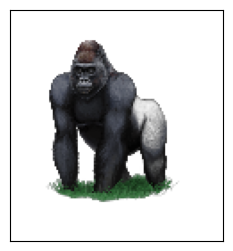

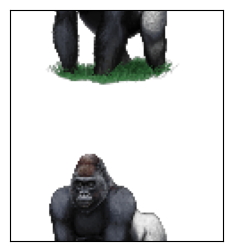

In [30]:
X = liedetect.datasets.GorillaImages(dim = 2, verbosity = 2)

Rips Complex is of dimension 2 - 1154400 simplices - 3900 vertices. Filtration maximal value is 0.15.


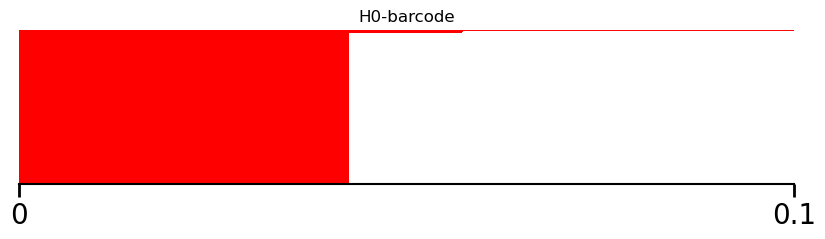

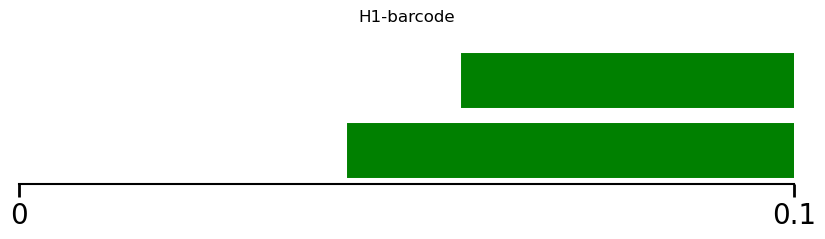

In [31]:
' Persistent homology '

# Rips filtration
dimension_max = 2  
st = velour.RipsComplex(X, filtration_max = 0.15, dimension_max = dimension_max)   #Rips filtration of X
velour.PlotPersistenceBarcodes(st, tmax=0.15, d=dimension_max-1, eps=0.03, homology_coeff_field=2)         #persistence of Rips filtration

PCA explained variance: [0.15163591 0.15163591 0.09496319 0.09496319 0.0718314  0.0718314 ]


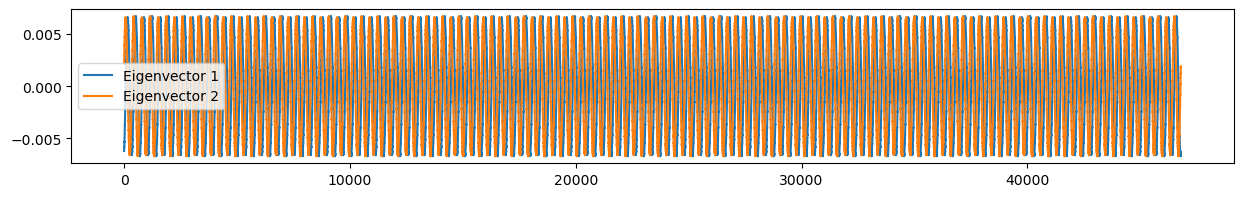

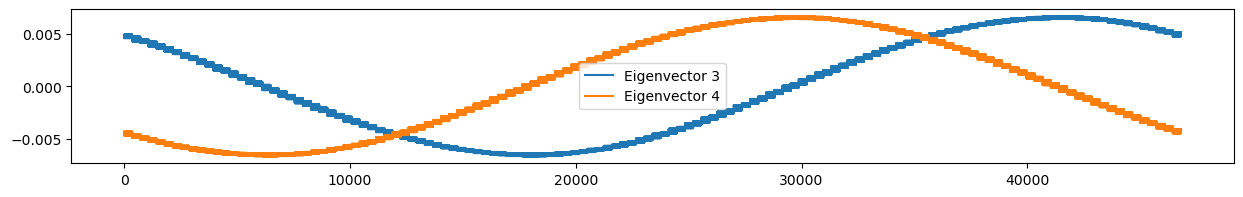

In [32]:
' Plot the eigenvectors of PCA '

n = 6

pca = sklearn.decomposition.PCA(n_components=n); pca.fit(X)
print('PCA explained variance:', pca.explained_variance_ratio_)

for I in range(2):
    plt.figure(figsize=(15,2))
    for i in range(2): plt.plot(pca.components_[2*I+i])
    plt.legend(['Eigenvector '+repr(2*I+1),'Eigenvector '+repr(2*I+2)])

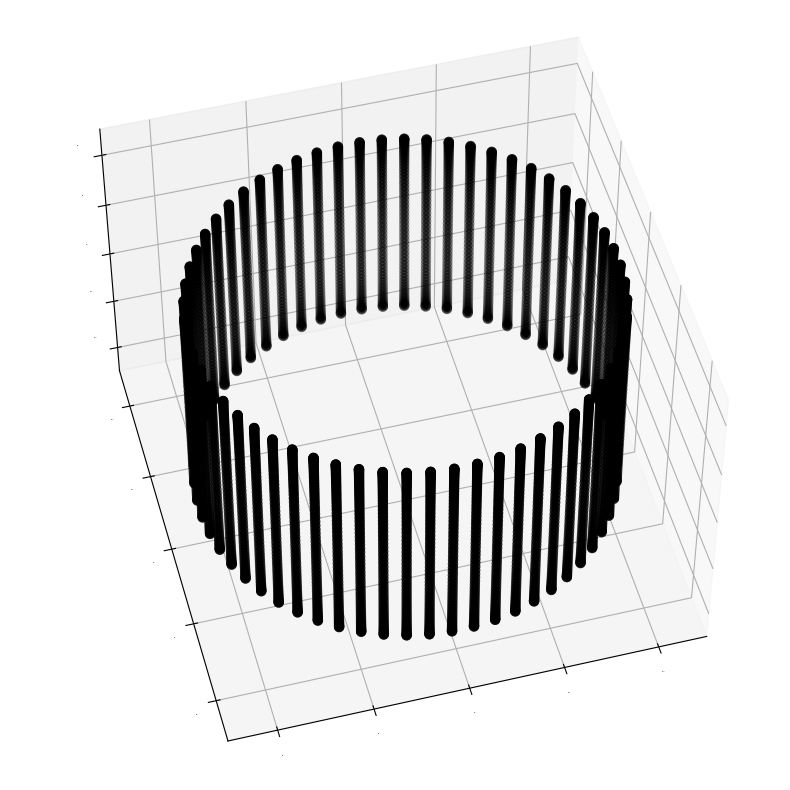

In [33]:
' Generate dataset '

# Parameters
dim = 2             # dimension of the torus (here, circle)
frequency_max = 4   # maximal angle parameter

# PCA
dim_pca = 6
ambient_dim = dim_pca
pca = sklearn.decomposition.PCA(n_components=dim_pca)
X = pca.fit_transform(X)

# Plot PCA
velour.PlotPCA(X); plt.show();

In [34]:
' Lie-PCA '

n_neighbors = 15

method='localPCA'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors, dim_pca,dim=dim,method=method)

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [1.0612777305316194e-13, 5.1619328760445796e-05, 0.06168681770244474, 0.061700424217364734]


----> Optimization problem via NormalForm <----
Test commutation: 0.0007115715456083043
There are 1728 frequencies to test.
The optimal frequencies found is ((3, -1, 2), (3, -2, 1)) cost: 0.0004185855592078466
              ---> equivalent to ((1, 2, 3), (2, 1, 3))
Non-symmetric Hausdorff distance from X to estimated orbit: 0.014373773854968956 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.015306358382513412


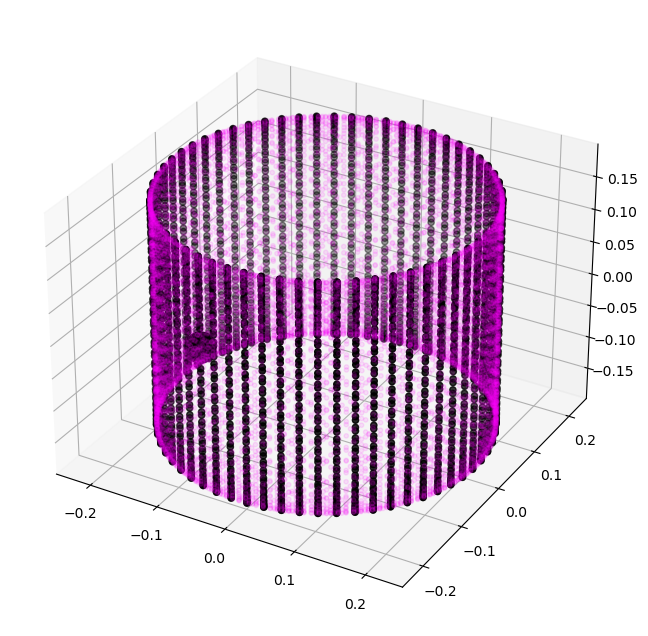

In [35]:
' Project on Lie subalgebras '
dim = 2            
frequency_max = 3

for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method, verbosity=2)
    # Generate estimated orbit
    n_points_orbit = 100
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=10,alpha=0.1); plt.show();

## Experiment II-4: $\mathbb{S}^1$ action on arrows

In [36]:
X = liedetect.datasets.ArrowImages()

PCA explained variance: [0.13689125 0.13686211 0.07483937 0.07481886 0.0743914  0.0743805
 0.07042581 0.07035384 0.02241529 0.02239859]


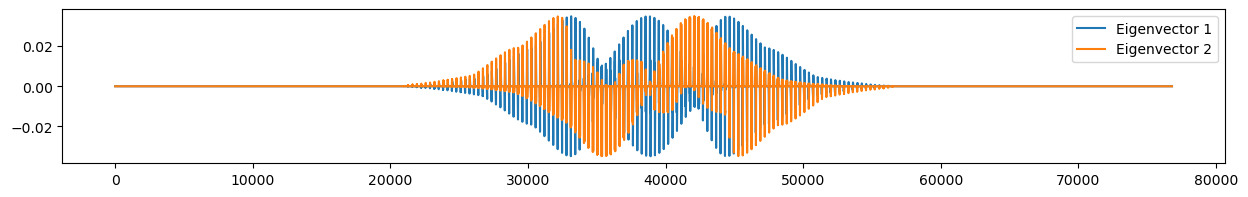

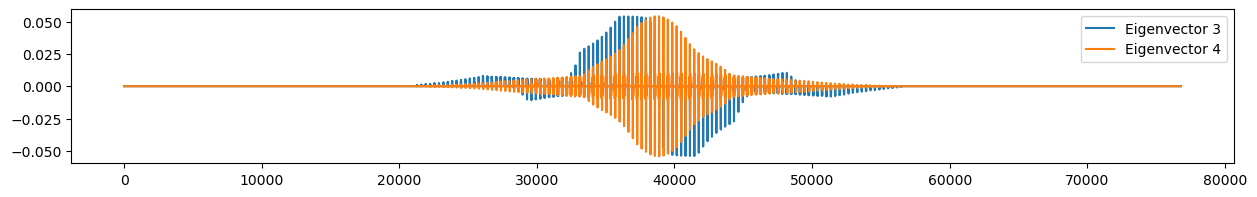

In [37]:
' Plot the eigenvectors of PCA '

n = 10

pca = sklearn.decomposition.PCA(n_components=n); pca.fit(X)
print('PCA explained variance:', pca.explained_variance_ratio_)

for I in range(2):
    plt.figure(figsize=(15,2))
    for i in range(2): plt.plot(pca.components_[2*I+i])
    plt.legend(['Eigenvector '+repr(2*I+1),'Eigenvector '+repr(2*I+2)])

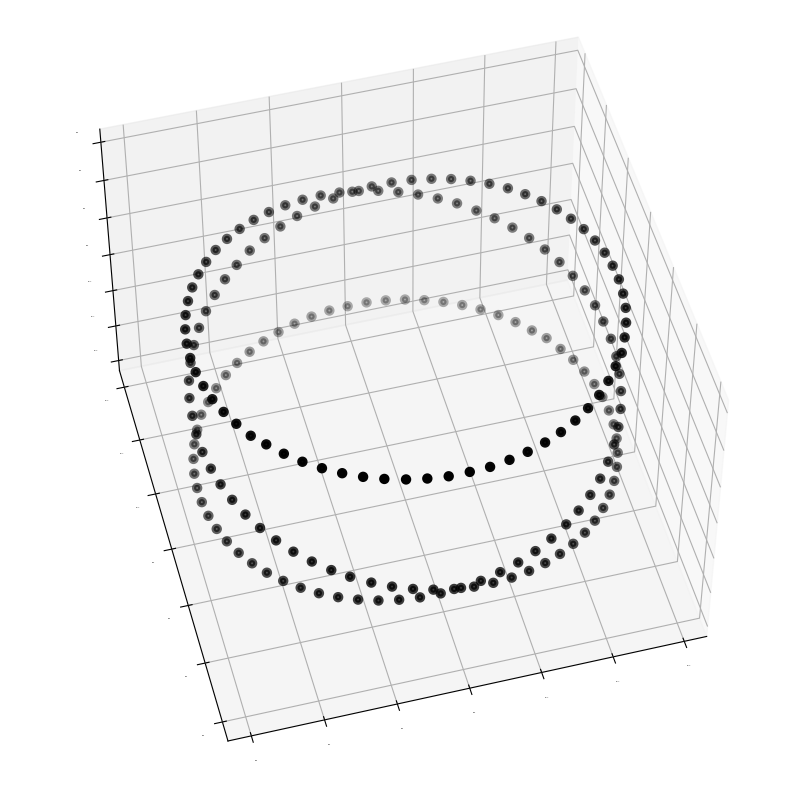

In [38]:
' Generate dataset '

# Parameters
dim = 1             # dimension of the torus (here, circle)
frequency_max = 6   # maximal angle parameter

# PCA
dim_pca = 8
ambient_dim = dim_pca
pca = sklearn.decomposition.PCA(n_components=dim_pca)
X = pca.fit_transform(X)


# Plot PCA
velour.PlotPCA(X); plt.show();

In [39]:
' Lie-PCA '

n_neighbors = 5

method='localPCA'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0004962369593997507, 0.04386413565348676, 0.043946693084807635, 0.05115138152155298]


----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.1627687732863088, 0.3248845745609112, 0.4839285764228277, 0.7960963965353827)
The optimal frequencies found is  ((1, 2, 3, 5),) with cost  0.007848936152568622
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0030460992989399466 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.004892920967443807


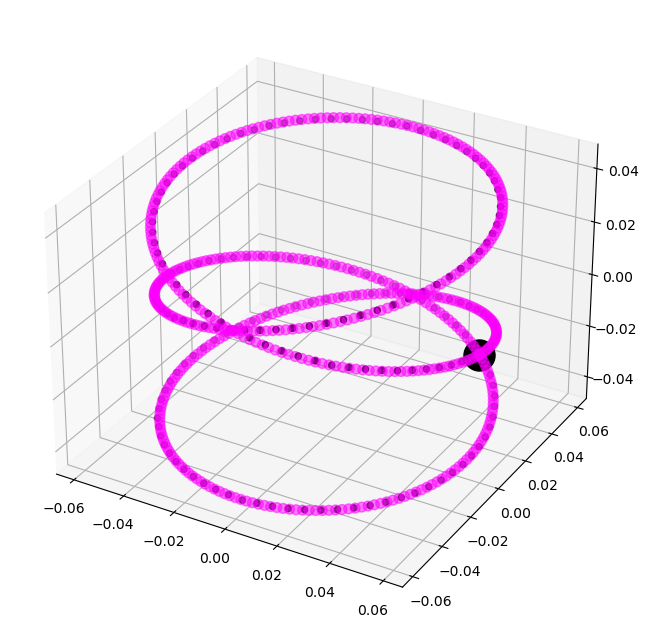

In [40]:
' Project on Lie subalgebras '

dim = 1            
frequency_max = 15

for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method, verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 500
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=50,alpha=0.5); plt.show();

## Experiment II-4: Rotated MNIST

In [2]:
number_of_rotations = 200
size_train = 1000
size_test = 100

X_train, y_train, X_test, y_test = liedetect.datasets.RotMNIST(number_of_rotations = number_of_rotations, 
                                                               size_train = size_train, size_test = size_test)

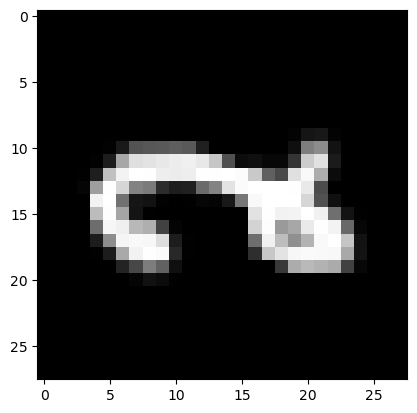

In [3]:
plt.imshow(X_train[0], cmap=plt.cm.gray)
plt.show()

In [4]:
X_train[:number_of_rotations].shape

(200, 28, 28)

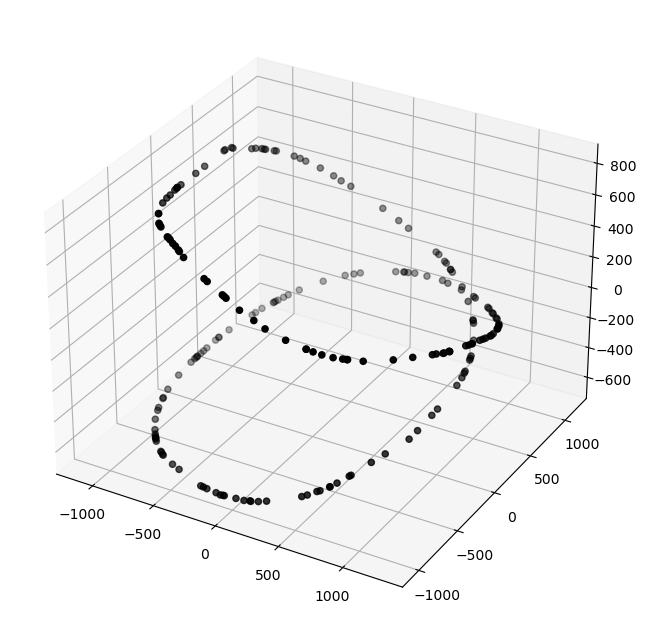

In [5]:
X = X_train[:number_of_rotations].reshape(number_of_rotations, 28*28)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black')
plt.show()

In [6]:
X =  X/max([np.linalg.norm(X[i]) for i in range(np.shape(X)[0])])

In [11]:
# Parameters
dim = 1             # dimension of the torus (here, circle)
frequency_max = 5  # maximal angle parameter

# PCA
dim_pca = 6
ambient_dim = dim_pca
pca = sklearn.decomposition.PCA(n_components=dim_pca)
X = pca.fit_transform(X)

In [12]:
' Lie-PCA '

n_neighbors = 5

method='localPCA'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.006417331073781743, 0.055537417676196826, 0.06359126549687784, 0.06889466804983535]


----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.2636493559127737, 0.533909720252077, 0.803386225763878)
The optimal frequencies found is  ((1, 2, 3),) with cost  0.003998650523096137
Non-symmetric Hausdorff distance from X to estimated orbit: 0.20391546011872994 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.21690126542025914


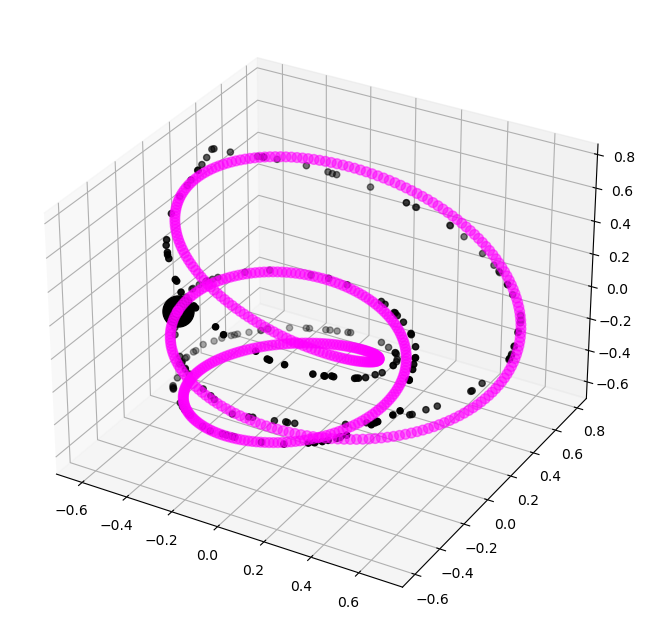

In [13]:
' Project on Lie subalgebras '
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method, verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 500
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=50,alpha=0.5); plt.show();

In [ ]:
import time

n_points_orbit = 500
n_neighbors = 5

X_train = X_train.reshape(number_of_rotations*size_train, 28*28)
    

X_train_orbits = []
y_train_orbits = np.array([])

start = time.time()
for i in range(size_train):
    X = X_train[i*number_of_rotations:(i+1)*number_of_rotations]
    pca = sklearn.decomposition.PCA(n_components=dim_pca)
    X = pca.fit_transform(X)
    X = X/max([np.linalg.norm(X[i]) for i in range(np.shape(X)[0])])
    Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method='localPCA'
                                                         , verbose = False)
    
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method='NormalForm', verbosity=0)
    X_train_orbits.append(liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, 
                                                                        OptimalFrequencies, n_points_orbit, x, dim))
    y_train_orbits = np.concatenate((y_train_orbits, 
                                                 y_train[i*number_of_rotations]*np.ones(n_points_orbit)),
                                               axis = None)
X_train_orbits = np.array(X_train_orbits)
X_train_orbits = X_train_orbits.reshape(n_points_orbit*size_train, dim_pca)
end = time.time()
print(end - start)

In [70]:
X_train_orbits.shape

(500000, 6)

In [71]:
y_train_orbits.shape

(500000,)

In [77]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_orbits, y_train_orbits)
knn.score(X_test_pca, y_test)

0.16

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
knn.score(X_test_pca, y_test)

0.49

# Experiments III - Harmonic analysis

## Experiment III: Gorilla with filter

shape X: (65, 60, 46800)


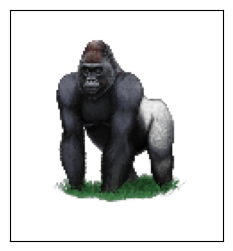

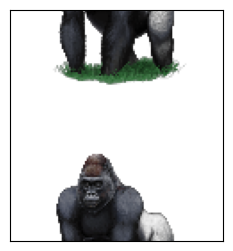

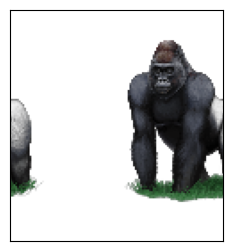

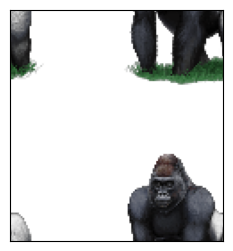

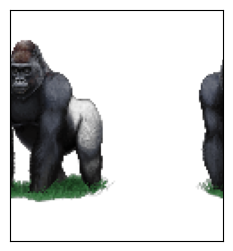

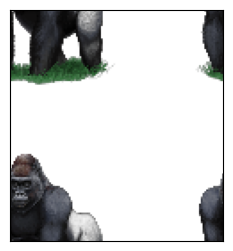

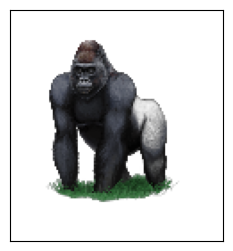

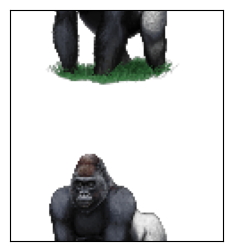

In [44]:
X = liedetect.datasets.GorillaImages(dim = 2, verbosity = 2)

In [45]:
shape = tuple([130, 120, 3])
X = X.reshape(65,60,-1)

def gaussian_filter(shape = shape, sigma = np.eye(2), plot = True):
    '''
    Creates a Gaussian filter os parameter sigma
    '''
    gs = np.ones(shape)
    mean = np.array([shape[0]/2, shape[1]/2])
    sigma_inv = np.linalg.inv(sigma)
    for i in range(130):
        for j in range(120):
            gs[i, j, :] =  np.exp(-1/2*(np.array([i,j])-mean).T@sigma_inv@(np.array([i,j])-mean))
    if plot:
        plt.imshow(gs)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.show()

    return gs

In [46]:
#makes the convolution of the signal (images) and the filter, which will be the dataset of interest
gs = gaussian_filter(sigma = 500*np.array([[1,0.7],[0.7,1]]), plot =  False) #defines the filter
frame = np.zeros((X.shape[:2]))
for i in range(-int(X.shape[0]/2), int(X.shape[0]/2)+1): #we go from negative to positive values so that
    for j in range(-int(X.shape[1]/2), int(X.shape[1]/2)): #the gorilla head is at (0,0) when centered
        frame[i,j] = sum(sum(sum(X[i+int(X.shape[0]/2),j+int(X.shape[1]/2),:].reshape(shape)*gs)))

In [50]:
def func_2D(beta, i, j, max_freq_fourrier, l, N_1, N_2):
    '''
    Defines a regressor for a 2D regression problem
    '''
    return sum([beta[l.index(str(n) + ' ' + str(m))]*np.exp(2*np.pi*n*1j*i/N_1)*np.exp(2*np.pi*m*1j*j/N_2) for n in range(-max_freq_fourrier, max_freq_fourrier + 1) for m in range(-max_freq_fourrier, max_freq_fourrier + 1)])[0]

def regression(X, y, N_1 = 65, N_2 = 60, max_freq_fourrier = 10):
    '''
    Performs the regression itself using the harmonic analysis decomposition
    '''
    N = X.shape[0]
    shape_transforms =  (N, (2*max_freq_fourrier + 1)**2)
    transform = np.ones(shape_transforms, dtype=np.complex_)
    for i in range(N):
        transform[i] =  np.array([np.exp(2*np.pi*n*1j*X[i][0]/N_1)*np.exp(2*np.pi*m*1j*X[i][1]/N_2) for n in range(-max_freq_fourrier, max_freq_fourrier + 1) for m in range(-max_freq_fourrier, max_freq_fourrier + 1)])
    transform_conj = transform.conjugate().T
    betas = np.linalg.pinv(transform_conj@transform)@transform_conj@y.reshape(N, 1)
    
    return betas

def predict(X, betas, N_1 = 65, N_2 = 60, max_freq_fourrier = 10):
    '''
    Predict the regression results
    '''
    l = [str(n) + ' ' + str(m) for n in range(-max_freq_fourrier, max_freq_fourrier + 1) for m in range(-max_freq_fourrier, max_freq_fourrier + 1)]
    
    prev = []
    for el in X:
        prev.append(func_2D(betas, el[0], el[1], max_freq_fourrier, l, N_1, N_2))
    return prev

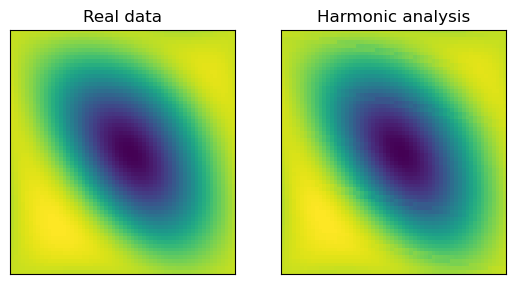

Error:  0.020569503461419378


In [68]:
N_1, N_2 = 65, 60 #creates the input data being the pixel locations
X = [(i,j) for i in range(N_2) for j in range(N_1)]
X = np.array(X)
y = frame.reshape(-1) #reshape the unknown to be a vector

from sklearn.model_selection import train_test_split #splits data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

beta = regression(X_train, y_train, N_1 = 65, N_2 = 60, max_freq_fourrier = 10) #estimate betas
prev_all = predict(X, beta) #makes the predictions

fig, axs = plt.subplots(1,2) #compares model predictions with actual data
axs[0].imshow(np.real(frame))
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])
axs[0].set_title('Real data')

axs[1].imshow(np.real(np.array(prev_all)).reshape(65,60))
axs[1].set_title('Harmonic analysis')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])
plt.show()
print('Error: ', sum((np.real(np.array(predict(X_test, beta)))-y_test)**2)/len(y_test))

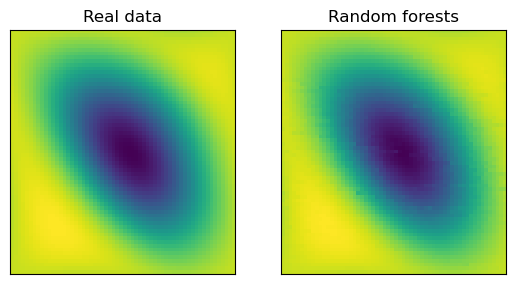

Error:  0.09336257165762804


In [69]:
#implements random forest to solve the problem
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state = 42)
regr.fit(X_train, y_train)


fig, axs = plt.subplots(1,2) #compares model predictions with actual data
axs[0].imshow(np.real(frame))
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])
axs[0].set_title('Real data')

axs[1].imshow(regr.predict(X).reshape(65,60))
axs[1].set_title('Random forests')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])
plt.show()

print('Error: ', sum((regr.predict(X_test)-y_test)**2)/len(y_test))

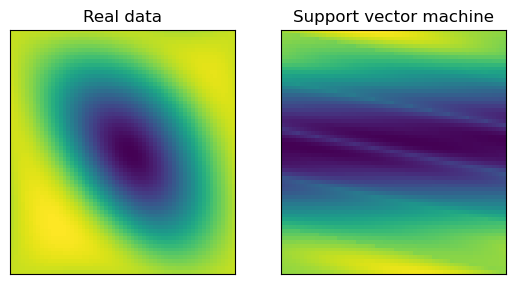

Error:  24.906809598039217


In [70]:
#implements support vector machines to solve the problem, with grid search
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


param_grid = {
    "SVR__C": [0.1, 1, 10, 100, 1000],
    "SVR__epsilon": [0.1, 0.2, 0.5, 1],
}

regr = Pipeline(steps = [('scaler', StandardScaler()), ('SVR',SVR())])
grid = GridSearchCV(regr, param_grid, refit = True, verbose = 0)


grid.fit(X_train, y_train)


fig, axs = plt.subplots(1,2) #compares model predictions with actual data
axs[0].imshow(np.real(frame))
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])
axs[0].set_title('Real data')

axs[1].imshow(grid.predict(X).reshape(65,60))
axs[1].set_title('Support vector machine')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])
plt.show()

print('Error: ', sum((grid.predict(X_test)-y_test)**2)/len(y_test))

In [71]:
import tensorflow as tf

def feedforward(number_of_layers, neurons_per_hidden_layer, activation, inputs_shape = 2):
    '''
    This function creates a simple feedforward neural network
    Input: number_of_layers: number of hidden layers in the network; neurons_per_hidden_layer: width of each hidden layer, which must be the
    same for all layers; activation: activation function for each hidden layer, which must be the same; inputs_shape = 3: shape of input
    set to 3 by default
    Output model of the neural network
    '''
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputs_shape,)))
    for i in range(number_of_layers):
        model.add(tf.keras.layers.Dense(neurons_per_hidden_layer, activation=activation))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    return model

def trains_network(model, number_of_epochs, data, target, verbose = 2, plot = False):
    '''
    Splits the dataset into train and validation and trains neurak network
    Input: model: the neural network to be trained; number_of_epochs: number of training epochs; data: dataset; target: dataset's labels;
    verbose = 2: verbose in training history;
    plot == False: if True, plots the training history
    '''
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size = 0.1, random_state = 42)
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_squared_error'])
    history = model.fit(X_train, y_train, epochs = number_of_epochs, validation_data = (X_val, y_val), batch_size=32, callbacks=[callback],
                        verbose = verbose)
    model.evaluate(data, target)
    
    if plot == True:
        plt.plot(history.history['val_loss'])
    return 

Epoch 1/100
99/99 - 8s - loss: 529.4702 - mean_squared_error: 529.4702 - val_loss: 407.4251 - val_mean_squared_error: 407.4251 - 8s/epoch - 76ms/step
Epoch 2/100
99/99 - 3s - loss: 389.2947 - mean_squared_error: 389.2947 - val_loss: 323.6014 - val_mean_squared_error: 323.6014 - 3s/epoch - 27ms/step
Epoch 3/100
99/99 - 1s - loss: 331.4992 - mean_squared_error: 331.4992 - val_loss: 279.2802 - val_mean_squared_error: 279.2802 - 971ms/epoch - 10ms/step
Epoch 4/100
99/99 - 1s - loss: 290.6223 - mean_squared_error: 290.6223 - val_loss: 245.0031 - val_mean_squared_error: 245.0031 - 1s/epoch - 11ms/step
Epoch 5/100
99/99 - 1s - loss: 252.4979 - mean_squared_error: 252.4979 - val_loss: 213.1716 - val_mean_squared_error: 213.1716 - 1s/epoch - 11ms/step
Epoch 6/100
99/99 - 1s - loss: 214.9358 - mean_squared_error: 214.9358 - val_loss: 182.7740 - val_mean_squared_error: 182.7740 - 1s/epoch - 11ms/step
Epoch 7/100
99/99 - 1s - loss: 185.1111 - mean_squared_error: 185.1111 - val_loss: 163.5737 - val

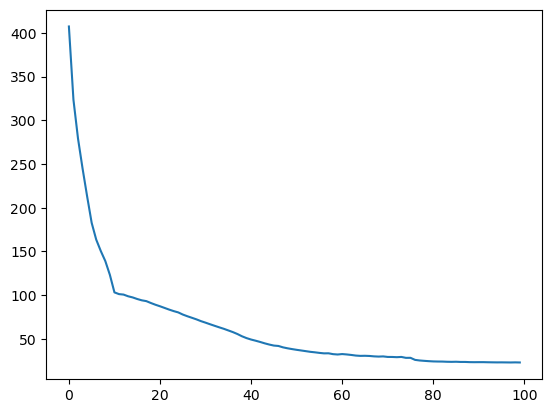

In [73]:
model = feedforward(2,3,'relu')
trains_network(model,100, X_train, y_train, plot= True )

122/122 [==============================] - 0s 881us/step


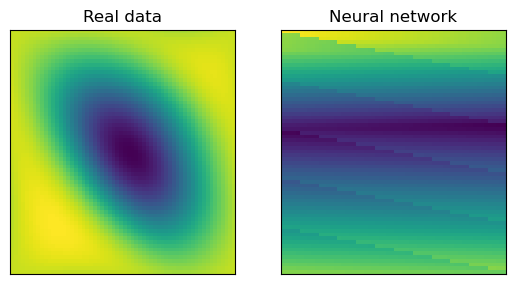

13/13 [==============================] - 0s 990us/step
Error:  25.326235102913834


In [74]:
fig, axs = plt.subplots(1,2) #compares model predictions with actual data
axs[0].imshow(np.real(frame))
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])
axs[0].set_title('Real data')

axs[1].imshow(model.predict(X).reshape(65, 60))
axs[1].set_title('Neural network')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])
plt.show()

print('Error: ', sum((model.predict(X_test).reshape(-1)-y_test)**2)/len(y_test))

# Experiments IV- Hamiltonian systems

## Experiment IV-I - Double harmonic oscillator

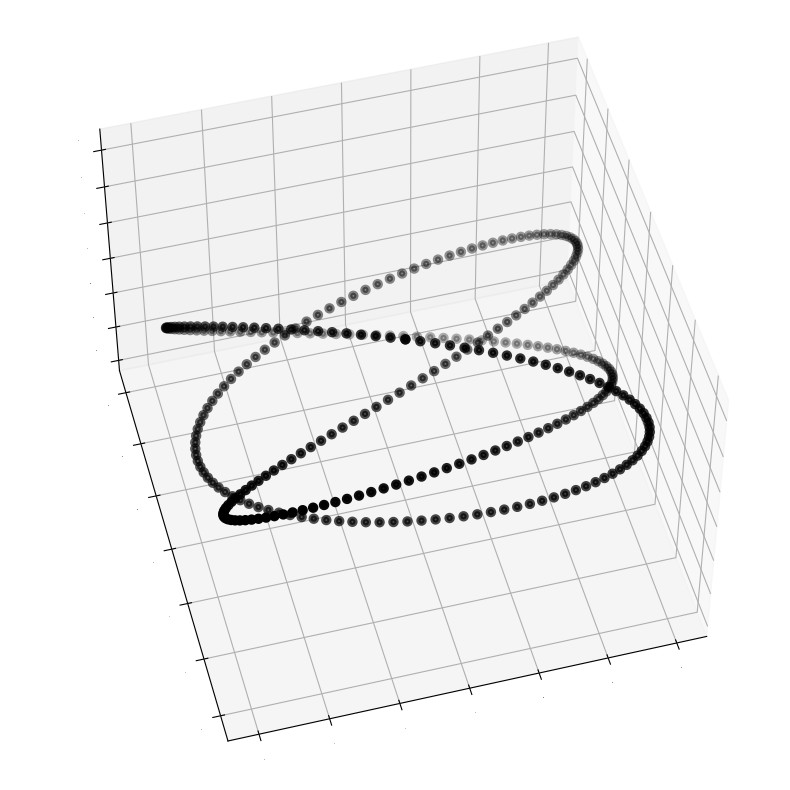

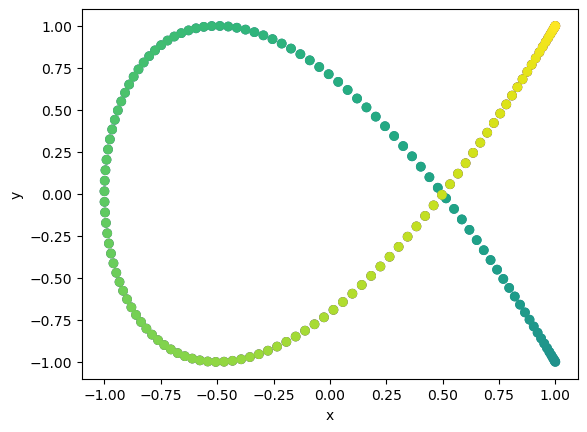

In [5]:
def oscillator(N = 300, k1 = 1, k2 = 2, t_max = 3*2*np.pi, x0 = 1, y0 = 1):
    '''
    Makes data for a simulation of two dimensional harmonic oscillator, 
    with N points, and coeficients k1 and k2. The system is released from (x0,y0)
    '''
    t = np.linspace(0, t_max, N)
    
    data = np.zeros((N, 4))
    
    data[:,0] = x0*np.cos(k1*t)
    data[:,1] = -k1*np.sin(k1*t)
    
    data[:,2] = y0*np.cos(k2*t)
    data[:,3] = -k2*np.sin(k2*t)
    
    return data

#makes an oscillator of coefficients k1 = 2 and k2 = 3
X = oscillator(k1 = 2, k2 = 3)
velour.PlotPCA(X); plt.show();


#plots x and y coordinates of the double oscillator
plot_position_data = oscillator(k1 = 2, k2 = 3, t_max = 2*np.pi)

plt.scatter(plot_position_data[:,0], plot_position_data[:,2] , 
            cmap = 'viridis', c = range(len(plot_position_data)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

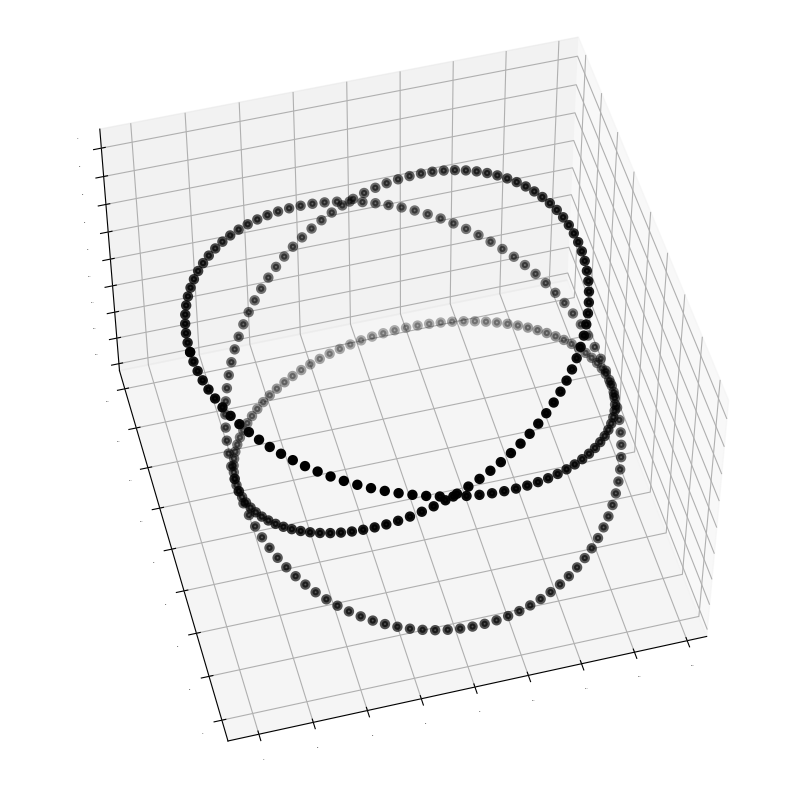

In [20]:
#applies Step 1 to the data set 
M, N = liedetect.project_sphere(X)

X = (N @ X.transpose()).transpose()
velour.PlotPCA(X); plt.show();

In [21]:
' Lie-PCA '

n_neighbors = 15

method='localPCA'
Sigma = liedetect.GetLiePCAOperator(X,n_neighbors, 2,dim=1,method=method)

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0001949713733735659, 0.12263710726057726, 0.12333307285932853, 0.12400433408588762]


----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.5601681277152077, 0.8283789402755473)
The optimal frequencies found is  ((2, 3),) with cost  0.006586130535438868
Non-symmetric Hausdorff distance from X to estimated orbit: 0.01622474389773788 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.02696678706573881


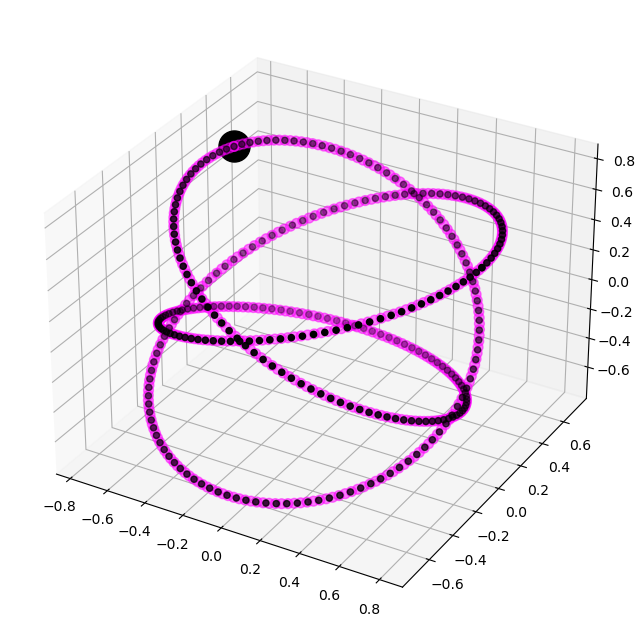

In [22]:
' Project on Lie subalgebras '

dim = 1            
frequency_max = 10

for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.FindClosestLieAlgebra(Sigma,dim,4, frequency_max=frequency_max,
                                                                                             method=method, verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 500
    x = X[0,:] #initial point of X
    Orbit = liedetect.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=50,alpha=0.5); plt.show();